In [1]:
from ultralytics import YOLO
import pickle
import pandas as pd

class TennisBallDetector:
		def __init__(self, model_path):
				self.model = YOLO(model_path)


		def detect_frames(self, frames, output_path=None, stub_path=None):
			'''
			Process the frames and return the detected balls.
			'''
			ball_positions = []
			if stub_path is not None:
				with open(stub_path, 'rb') as f:
					ball_positions = pickle.load(f)
					return ball_positions
			for i, frame in enumerate(frames):
				results = self.results(frame)
				ball_positions.append(results)
			if output_path is not None:
				with open(output_path, 'wb') as f:
					pickle.dump(ball_positions, f)
			return ball_positions

		def results(self, frame):
			'''
			Process the frame and return the detected balls.
			'''
			results = self.model.predict(frame, conf=0.15)[0]
			id_name_dict = results.names
			ball_dict = {}
			for box in results.boxes:
				result = box.xyxy.tolist()[0]
				ball_dict[0] = result
			return ball_dict
		
		def interpolate(self, ball_detections):
			# Replace empty detections with None
			for i, ball in enumerate(ball_detections):
				if not ball:
					ball_detections[i] = None

			data = {
				'frame': list(range(len(ball_detections))),
				'ball_position': ball_detections
			}
			df = pd.DataFrame(data)
			df.set_index('frame', inplace=True)
			df[['x1', 'y1', 'x2', 'y2']] = df['ball_position'].apply(self.extract_coordinates)
			df[['x1', 'y1', 'x2', 'y2']] = df[['x1', 'y1', 'x2', 'y2']].interpolate()
			df['ball_position'] = df.apply(self.assemble_coordinates, axis=1)
			ball_detections = df['ball_position'].tolist()
			# Convert None to empty dict
			for i, ball in enumerate(ball_detections):
				if ball is None:
					ball_detections[i] = {}
			return ball_detections
			
		def extract_coordinates(self, row):
			if row and 0 in row:
					return pd.Series(row[0])
			else:
					return pd.Series([None, None, None, None],dtype=float)
			
		def assemble_coordinates(self, row):
			if not pd.isna(row['x1']):
					return {0: [row['x1'], row['y1'], row['x2'], row['y2']]}
			else:
					return None

In [2]:
def read_frames(cap):
	'''
	Read the frames of a video
	Parameters:
		cap: The video capture object
	Returns:
		frames: A list of frames
	'''
	frames = []
	while True:
		ret, frame = cap.read()
		if not ret: break
		frames.append(frame)
	return frames

In [3]:
import cv2
video_path = f'../data/raw/videos/match01.mp4'
cap = cv2.VideoCapture(video_path)
cap = cv2.VideoCapture(video_path)
# Out Video Configuration
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# Frames
frames = read_frames(cap) 

In [4]:
ball_detector = TennisBallDetector('../models/tennis_ball/last.pt')

In [5]:
ball_detections = ball_detector.detect_frames(frames,stub_path=f'../output/stubs/balls-match01.pkl')
ball_detections = ball_detector.interpolate(ball_detections)
# Filter out empty detections (empty keys)
ball_positions = [ball[0][1] for ball in ball_detections if ball]

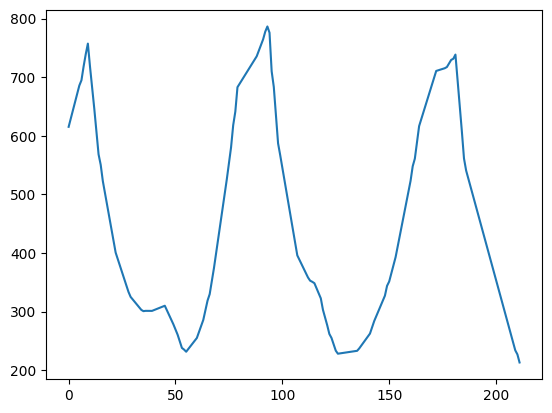

In [6]:
# Plot all the detections - x index is the frame number

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

number_of_frames = len(ball_positions)
velocities = np.diff(ball_positions, n=1)
# Detect zero crossings
frame_numbers = np.arange(0, number_of_frames)
zero_crossings = np.where(np.diff(np.sign(velocities)))[0]
plt.plot(frame_numbers[:-1], ball_positions[:-1], label='Ball Position')

In [7]:
# Thresholds for significant deviation and minimum number of consecutive points
deviation_threshold = 100  # adjust based on your observations
min_consecutive_points = 10  # number of consecutive points to confirm a trend

In [8]:
# Obtain the velocities
velocities = np.diff(ball_positions, n=1)

In [9]:
# Detect zero crossings
frame_numbers = np.arange(0, number_of_frames)
zero_crossings = np.where(np.diff(np.sign(velocities)))[0]

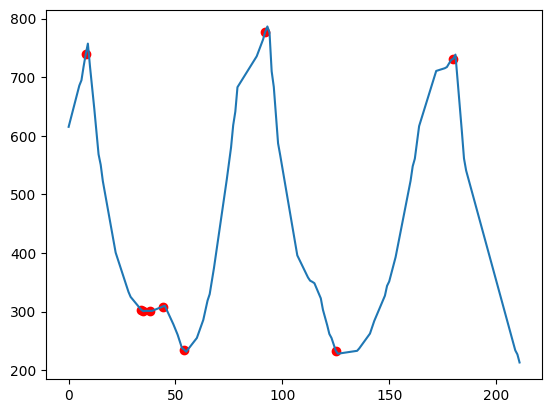

In [10]:
# Plot zero crossings
plt.scatter(zero_crossings, np.array(ball_positions)[zero_crossings], color='red', label='Zero Crossing')
# Plot the ball positions
plt.plot(frame_numbers[:-1], ball_positions[:-1], label='Ball Position')


In [11]:
from scipy.signal import argrelextrema
ball_positions = np.array(ball_positions)
# Find local maxima and minima
local_max = argrelextrema(ball_positions, np.greater)[0]
local_min = argrelextrema(ball_positions, np.less)[0]

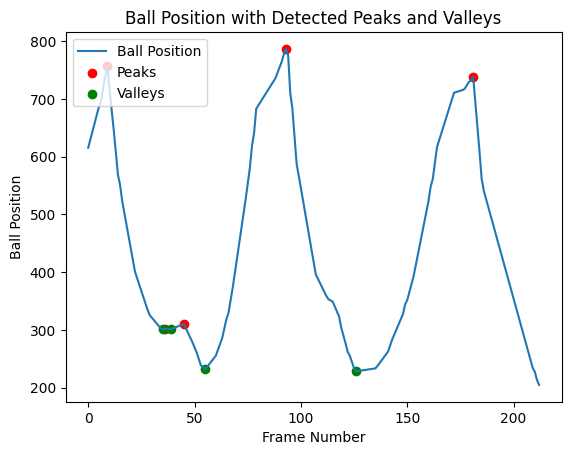

In [12]:
# Plot the ball positions
plt.plot(frame_numbers, ball_positions, label='Ball Position')

# Plot maxima and minima
plt.scatter(local_max, ball_positions[local_max], color='red', marker='o', label='Peaks')
plt.scatter(local_min, ball_positions[local_min], color='green', marker='o', label='Valleys')

plt.title('Ball Position with Detected Peaks and Valleys')
plt.xlabel('Frame Number')
plt.ylabel('Ball Position')
plt.legend()
plt.show()

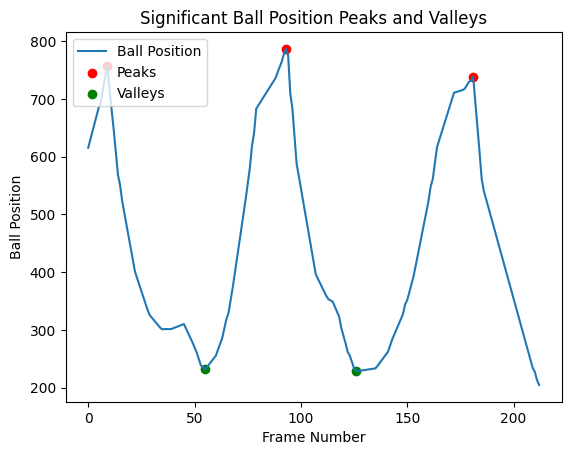

In [13]:
from scipy.signal import find_peaks
# Parameters
min_distance = 50  # Minimum number of frames between peaks
# prominence_val = 50  # Adjust this based on your observations

# Find peaks
peaks, _ = find_peaks(ball_positions, distance=min_distance)
# Find valleys by inverting the data
valleys, _ = find_peaks(-ball_positions, distance=min_distance)

# Plot the ball positions
plt.plot(frame_numbers, ball_positions, label='Ball Position')
plt.scatter(peaks, ball_positions[peaks], color='red', marker='o', label='Peaks')
plt.scatter(valleys, ball_positions[valleys], color='green', marker='o', label='Valleys')

plt.title('Significant Ball Position Peaks and Valleys')
plt.xlabel('Frame Number')
plt.ylabel('Ball Position')
plt.legend()
plt.show()

In [14]:
hit_counts = np.zeros(number_of_frames)

In [15]:
hit_frames = np.concatenate((peaks, valleys))

In [16]:
total_hits = 0
for i in range(0, number_of_frames):
		if i in hit_frames:
				hit_counts[i] = total_hits + 1
				total_hits += 1
		else:
				hit_counts[i] = total_hits
		

In [17]:
hit_counts

array([          0,           0,           0,           0,           0,           0,           0,           0,           0,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,
                 1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,
                 1,           1,           1,           1,           1,           1,           1,           2,           2,           2,           2,           2,           2,           2,           2,           2,           2,           2,           2,           2,           2,           2,           2,           2,
                 2,           2,           

In [18]:
def detect_ball_hits(ball_positions):
		# Parameters
		min_distance = 50  # Minimum number of frames between peaks
		# Find peaks
		peaks, _ = find_peaks(ball_positions, distance=min_distance)
		# Find valleys by inverting the data
		valleys, _ = find_peaks(-ball_positions, distance=min_distance)
		hit_frames = np.concatenate((peaks, valleys))
		hit_counts = np.zeros(len(ball_positions))
		total_hits = 0
		for i in range(0, len(ball_positions)):
				if i in hit_frames:
						hit_counts[i] = total_hits + 1
						total_hits += 1
				else:
						hit_counts[i] = total_hits
		return hit_counts